# Maximum Entropy Forecasting Pipeline

This notebook demonstrates the full pipeline:
1. Generate relevant variables for a forecasting question
2. Generate probability/expectation estimates using natural language format
3. Build a maximum entropy distribution from the estimates

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

# Check API key is set
assert os.getenv("OPENROUTER_API_KEY"), "Set OPENROUTER_API_KEY in .env file"

## Step 1: Set up the LLM client and generators

In [2]:
from calibrated_response.llm.openrouter import OpenRouterClient
from calibrated_response.generation.variable_generator import VariableGenerator
from calibrated_response.generation.natural_estimate_generator import NaturalEstimateGenerator

# Initialize the LLM client
llm = OpenRouterClient(
    model="google/gemini-2.5-pro",
    providers=["Google"],  # Route to Google for best Gemini performance
)

# Initialize generators
var_gen = VariableGenerator(llm)
est_gen = NaturalEstimateGenerator(llm)

## Step 2: Define the forecasting question

In [6]:
question = """Will the AI bubble burst by the end of 2030, or will AI continue to grow and integrate into various industries, leading to sustained interest and investment?"""

print(f"Forecasting question: {question}")

Forecasting question: Will the AI bubble burst by the end of 2030, or will AI continue to grow and integrate into various industries, leading to sustained interest and investment?


## Step 3: Generate relevant variables

In [8]:
# Generate variables that might influence the forecast
variables = var_gen.generate(question, n_variables=10)

print(f"Generated {len(variables)} variables:\n")
for v in variables:
    print(f"  - {v.name} ({v.type.value}): {v.description}")
    if hasattr(v, 'lower_bound') and hasattr(v, 'upper_bound'):
        unit = getattr(v, 'unit', '') or ''
        print(f"    Domain: [{v.lower_bound}, {v.upper_bound}] {unit}")

Generated 10 variables:

  - ai_bubble_bursts_by_2030 (binary): Will a significant, rapid, and sustained market correction (greater than 40% decline in a major AI-related index from its peak) occur in the AI sector by the end of 2030?
  - peak_annual_ai_vc_funding (continuous): The peak annual global venture capital investment into AI-focused companies in any single year between 2024 and 2029.
    Domain: [50.0, 1000.0] billions_of_USD
  - ai_revenue_growth_rate (continuous): The compound annual growth rate (CAGR) of revenue directly attributable to AI for the top 10 public AI companies from 2024 to 2029.
    Domain: [5.0, 150.0] percent
  - major_agi_breakthrough (binary): Will a generally recognized breakthrough towards Artificial General Intelligence (AGI), such as a model demonstrating robust cross-domain reasoning, occur by 2029?
  - stringent_ai_regulation (binary): Will major economic blocs (e.g., US, EU, China) implement stringent, growth-inhibiting regulations on AI developmen

In [10]:
var_ind = [0, 1, 3, 7, 8, 9]
selected_vars = [variables[i] for i in var_ind]
print("\nSelected variables for estimation:")
for v in selected_vars:
    print(f"  - {v.name} ({v.type.value}): {v.description}")


Selected variables for estimation:
  - ai_bubble_bursts_by_2030 (binary): Will a significant, rapid, and sustained market correction (greater than 40% decline in a major AI-related index from its peak) occur in the AI sector by the end of 2030?
  - peak_annual_ai_vc_funding (continuous): The peak annual global venture capital investment into AI-focused companies in any single year between 2024 and 2029.
  - major_agi_breakthrough (binary): Will a generally recognized breakthrough towards Artificial General Intelligence (AGI), such as a model demonstrating robust cross-domain reasoning, occur by 2029?
  - killer_app_revenue (continuous): The annual revenue generated by the single most successful AI-native application or platform by 2029.
  - global_recession_occurs (binary): Will a global recession, as defined by the IMF, be declared for at least two consecutive quarters between mid-2024 and 2030?
  - interest_rate_peak (continuous): The peak US Federal Funds Rate reached between now a

## Step 4: Generate estimates using natural language format

In [17]:
# Generate estimates in natural language format
estimates = est_gen.generate(
    question=question,
    variables=selected_vars,
    num_estimates=30,
)

print(f"Generated {len(estimates)} estimates:\n")
for est in estimates:
    print(f"  {est.to_query_estimate()}")

Generated 30 estimates:

  P(ai_bubble_bursts_by_2030 = True) = 0.45
  E[peak_annual_ai_vc_funding] = 250.0
  P(major_agi_breakthrough = True) = 0.3
  E[killer_app_revenue] = 60.0
  P(global_recession_occurs = True) = 0.6
  E[interest_rate_peak] = 5.5
  P(ai_bubble_bursts_by_2030 = True | major_agi_breakthrough = True) = 0.65
  P(ai_bubble_bursts_by_2030 = True | major_agi_breakthrough = False) = 0.4
  P(ai_bubble_bursts_by_2030 = True | global_recession_occurs = True) = 0.75
  P(ai_bubble_bursts_by_2030 = True | killer_app_revenue < 50.0) = 0.55
  P(ai_bubble_bursts_by_2030 = True | killer_app_revenue > 100.0) = 0.25
  P(ai_bubble_bursts_by_2030 = True | interest_rate_peak > 6.0) = 0.6
  P(ai_bubble_bursts_by_2030 = True | peak_annual_ai_vc_funding > 400.0) = 0.7
  E[peak_annual_ai_vc_funding | major_agi_breakthrough = True] = 500.0
  E[peak_annual_ai_vc_funding | global_recession_occurs = True] = 180.0
  E[peak_annual_ai_vc_funding | killer_app_revenue > 100.0] = 350.0
  P(major_agi_

## Step 5: Build the maximum entropy distribution

In [22]:
from calibrated_response.maxent.distribution_builder import DistributionBuilder
from calibrated_response.maxent.multivariate_solver import JAXSolverConfig

# Configure the solver
config = JAXSolverConfig(
    max_bins=10,      # Number of bins for discretization
    maxiter=500,    # Maximum optimization iterations
    tolerance=1e-6,         # Convergence tolerance
    constraint_weight=1.0e2,
    regularization_type='kl_gaussian',  # Regularization to prevent overfitting
)

# Build the distribution
builder = DistributionBuilder(
    variables=selected_vars,
    estimates=estimates,
    solver_config=config,
)

print(f"Built constraints from {len(builder.constraints)} estimates")

Built constraints from 30 estimates


In [23]:
target_var = variables[0]
print(f"Target variable: {target_var.name}")

distribution, info = builder.build(target_variable=target_var.name)

print(f"\nSolver info:")
for key, val in info.items():
    if key not in ['joint_distribution', 'bin_edges_list']:
        print(f"  {key}: {val}")

Target variable: ai_bubble_bursts_by_2030

Solver info:
  n_iterations: 500
  final_loss: 17.3596134185791
  entropy: 3.437012195587158
  converged: False
  error: 0.029860202223062515
  state: LbfgsState(iter_num=Array(500, dtype=int32, weak_type=True), value=Array(17.35956, dtype=float32), grad=Array([ 1.7985128e-04,  1.8292555e-04,  1.8561579e-04, ...,
       -1.1810528e-05, -1.1138100e-05, -1.0392662e-05], dtype=float32), stepsize=Array(0.7584577, dtype=float32), error=Array(0.0298602, dtype=float32), s_history=Array([[-0.00167952, -0.00169078, -0.00169539, ..., -0.00142917,
        -0.00143084, -0.00143161],
       [-0.00464583, -0.00476272, -0.00484439, ..., -0.00292206,
        -0.00280619, -0.00268728],
       [-0.00044988, -0.00051803, -0.00057166, ...,  0.00041398,
         0.00050503,  0.0005967 ],
       ...,
       [ 0.00027274,  0.00025943,  0.00024749, ...,  0.0005236 ,
         0.00054288,  0.00056201],
       [-0.00093365, -0.00096248, -0.00098339, ..., -0.00047714,
  

## Step 6: Visualize the distribution

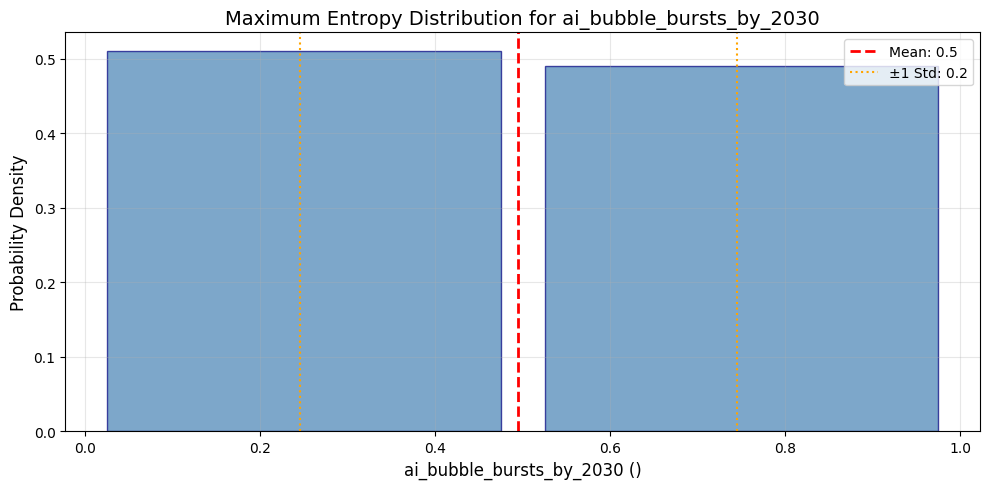


Statistics:
  Mean: 0.50
  Std Dev: 0.25
  90% CI: [0.08, 0.91]


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the distribution
fig, ax = plt.subplots(figsize=(10, 5))

bin_edges = np.array(distribution.bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]
probs = np.array(distribution.bin_probabilities)

ax.bar(bin_centers, probs, width=bin_widths * 0.9, alpha=0.7, color='steelblue', edgecolor='navy')
ax.set_xlabel(f"{target_var.name} ({getattr(target_var, 'unit', '')})", fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.set_title(f'Maximum Entropy Distribution for {target_var.name}', fontsize=14)
ax.grid(True, alpha=0.3)

# Add statistics
mean = np.sum(probs * bin_centers)
variance = np.sum(probs * (bin_centers - mean) ** 2)
std = np.sqrt(variance)

ax.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean:.1f}')
ax.axvline(mean - std, color='orange', linestyle=':', linewidth=1.5, label=f'±1 Std: {std:.1f}')
ax.axvline(mean + std, color='orange', linestyle=':', linewidth=1.5)
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nStatistics:")
print(f"  Mean: {mean:.2f}")
print(f"  Std Dev: {std:.2f}")
print(f"  90% CI: [{mean - 1.645*std:.2f}, {mean + 1.645*std:.2f}]")

## Step 7: Get all marginal distributions

In [25]:
# Get marginal distributions for all variables
all_marginals = builder.get_all_marginals(info)

print(f"Computed marginals for {len(all_marginals)} variables:")
for var_name, dist in all_marginals.items():
    bin_centers = (np.array(dist.bin_edges[:-1]) + np.array(dist.bin_edges[1:])) / 2
    mean = np.sum(np.array(dist.bin_probabilities) * bin_centers)
    print(f"  {var_name}: mean = {mean:.2f}, bins = {len(dist.bin_edges)-1}")

Computed marginals for 6 variables:
  ai_bubble_bursts_by_2030: mean = 0.50, bins = 2
  peak_annual_ai_vc_funding: mean = 310.15, bins = 10
  major_agi_breakthrough: mean = 0.43, bins = 2
  killer_app_revenue: mean = 110.80, bins = 10
  global_recession_occurs: mean = 0.59, bins = 2
  interest_rate_peak: mean = 5.12, bins = 10


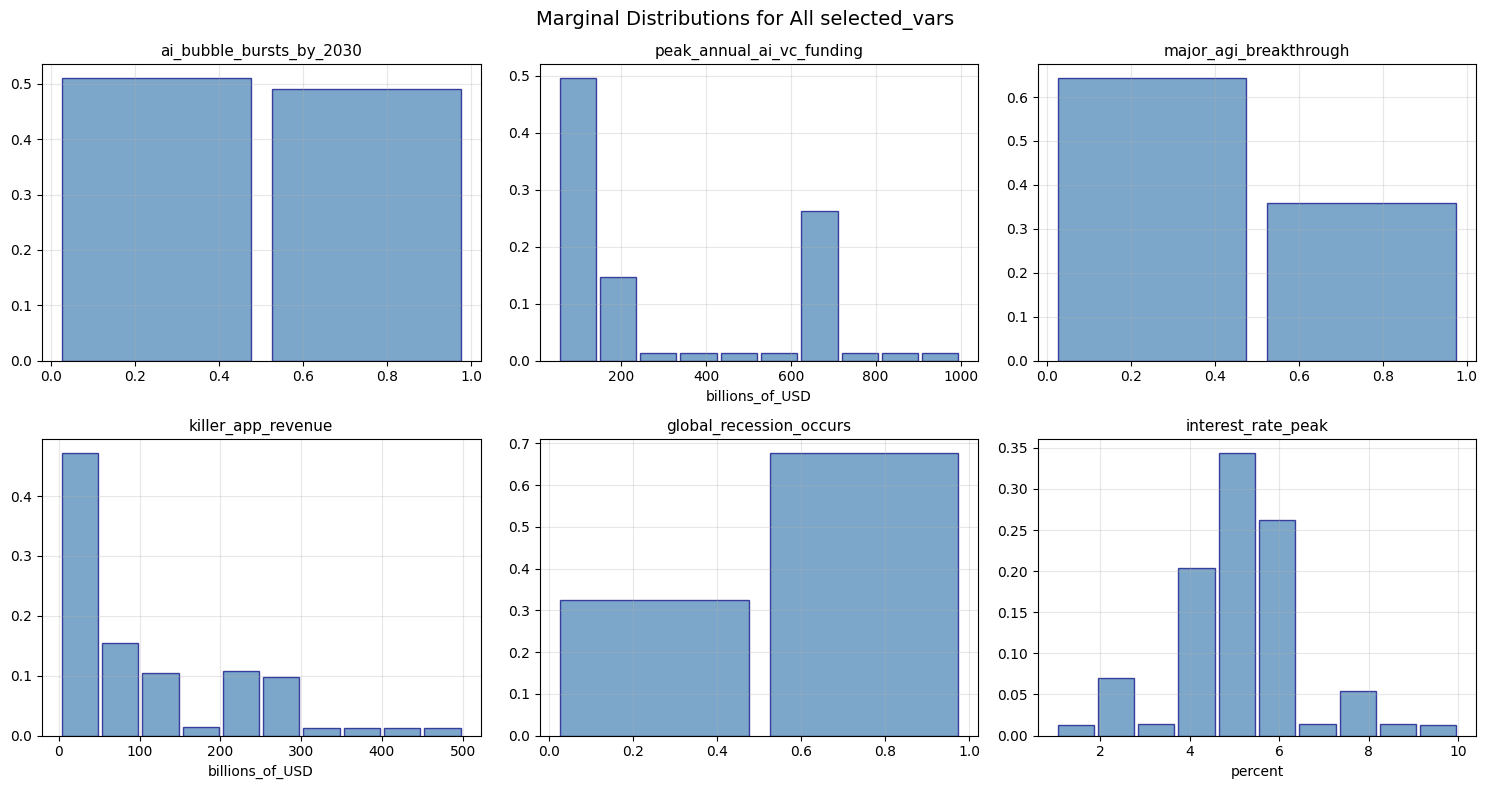

In [27]:
# Plot all marginals in a grid
n_vars = len(selected_vars)
n_cols = min(3, n_vars)
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_vars == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, var in enumerate(selected_vars):
    ax = axes[idx]
    dist = all_marginals[var.name]
    
    bin_edges = np.array(dist.bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    probs = np.array(dist.bin_probabilities)
    
    ax.bar(bin_centers, probs, width=bin_widths * 0.9, alpha=0.7, color='steelblue', edgecolor='navy')
    ax.set_title(var.name, fontsize=11)
    ax.set_xlabel(getattr(var, 'unit', '') or '', fontsize=10)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_vars, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Marginal Distributions for All selected_vars', fontsize=14)
plt.tight_layout()
plt.show()

## Step 8: Pairwise Marginal Plot

Visualize the relationships between all pairs of variables using a lower triangular plot.
- **Diagonal**: 1D marginal distributions with mean indicator
- **Lower triangle**: 2D joint marginal heatmaps
- **Upper triangle**: Empty (symmetric information)

The target variable is placed in the first row/column for easy comparison.

In [ ]:
from calibrated_response.visualization.pairplot import plot_pairwise_marginals

# Get the joint distribution and bin edges from the last build
joint_dist = info['joint_distribution']
bin_edges = info['bin_edges_list']

# Create the pairwise plot
fig = plot_pairwise_marginals(
    joint_distribution=joint_dist,
    bin_edges_list=bin_edges,
    variables=selected_vars,
    target_variable=target_var.name,
    constraints=builder.constraints,
    figsize=(12, 12),
    cmap='Blues',
)

plt.show()